In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from statsmodels.graphics.tsaplots import plot_acf
import random as rd
import seaborn as sns
from tqdm import tqdm

In [2]:
df = pd.read_csv("listeria.csv", names=['positive','total'])

In [3]:
df['ratio'] = df['positive'] / df['total']
ratio = df['ratio']

In [4]:
def indicatrice1(x):
    if x <1 and x>0:
        return 1
    else:
        return 0

def indicatrice2(x):
    if x >0:
        return 1
    else:
        return 0

In [5]:
def metropolis_within_gibbs_melange(x,sigma_mu0=0.015,sigma_kap0=0.1,sigma_mu1=0.015,sigma_kap1=0.1,eta=0.5):
    
    # previous value of kappa0 kappa1 mu0 mu1
    mu0=x[182]      
    kap0=x[183]     
    mu1=x[184] 
    kap1=x[185]    
    
    y=np.zeros(186)  # initialisation vecteur y
    
    
    ## w_i
    
    for i in range(0,91):
        if x[i]==0:
            r = 0.5 
            seuil=np.log(r)  
        else:
            seuil = (mu1*kap1-mu0*kap0)*np.log(x[i]) + ((1-mu1)*kap1-(1-mu0)*kap0)*np.log(1 - x[i]) + np.log(eta) - np.log(1-eta)
        
        if np.log(np.random.rand()) < seuil:       # w_i =1
            y[91+i]=1
            
        else:
            y[91+i]=0
        
    ## p_i
    
    for i in range(0,91):
        if y[91+i]==1:                 
            a = mu1*kap1+df['positive'][i]
            b = df['total'][i]-df['positive'][i]+kap1*(1-mu1)
            y[i]=np.random.beta(a,b)
            
        else:     
            a = mu0*kap0+df['positive'][i]
            b = df['total'][i]-df['positive'][i]+kap0*(1-mu0)
            y[i]=np.random.beta(a,b)
    
    
    ## mu0
    
    z = mu0 + sigma_mu0 * np.random.randn()
    accept = True
    
    if indicatrice1(z)==0:
        accept=False
        seuil=-np.inf
    else:
        seuil=(kap0*(z-mu0))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91) if (y[91+i]==0 and y[i]!=0)]))
                                                                   
    if np.log(np.random.rand()) < seuil and accept:            
        mu0 = z
        
    y[182]=mu0

        
    
    ## mu1
    
    z = mu1 + sigma_mu1 * np.random.randn()
    accept = True
    
    if indicatrice1(z)==0:
        accept = False
        seuil=-np.inf
    else:
        seuil=(kap1*(z-mu1))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91) if (y[91+i]==1 and y[i]!=0)]))
                                                                   
    if np.log(np.random.rand()) < seuil and accept:            
        mu1 = z
        
    y[184]=mu1

     
    ## kappa0
    
    z = kap0 + sigma_kap0 * np.random.randn()
    accept = True
    
    if indicatrice2(z)==0:
        accept = False
        seuil=-np.inf
    else:
        quantite_1=-0.1*(z-kap0)
        quantite_2=(mu0*(z-kap0))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91) if (y[91+i]==0 and y[i]!=0)]))
        quantite_3=(z-kap0)*(sum([np.log(1-y[i]) for i in range(0,91) if y[91+i]==0]))
        seuil=quantite_1+quantite_2+quantite_3
        
    if np.log(np.random.rand()) < seuil and accept:           
        kap0=z
        
    y[183]=kap0

        
    
    ## kappa1
    
    z = kap1 + sigma_kap1 * np.random.randn()
    accept=True
    
    if indicatrice2(z)==0:
        accept = False
        seuil=-np.inf
    else:
        quantite_1=-0.1*(z-kap1)
        quantite_2=(mu1*(z-kap1))*(sum([np.log(y[i]/(1-y[i])) for i in range(0,91) if (y[91+i]==1 and y[i]!=0)]))
        quantite_3=(z-kap1)*(sum([np.log(1-y[i]) for i in range(0,91) if y[91+i]==1]))
        seuil=quantite_1+quantite_2+quantite_3
        
    if np.log(np.random.rand()) < seuil and accept:           
        kap1=z
        
    y[185]=kap1

    
    return y     

In [6]:
# initialisation de vecteur y 
# 186 paramètres (les 91 p_i + les 91 w_i +mu0 + kap0 + mu1 + kap1 )
                   

N = 4000
y = np.zeros((N, 186))

for i in range (0,91):
    y[0,i]=df['ratio'][i]           # on prend les probas empiriques comme probas initiales
    
for i in range(91,182):
    y[0,i]=np.random.binomial(1,0.5)   # on prend des valeurs au hasard (0 ou 1) comme w_i initiales
    
y[0,182]=0.5         # valeur initiale pour mu0 car mu0 suit une uniforme sur [0,1]
y[0,183]=10          # valeur initiale pour kappa0 car kappa0 suit une exp(0.1) donc est de moyenne 10
y[0,184]=0.5         # valeur initiale pour mu1 
y[0,185]=10          # valeur initiale pour kappa1

In [20]:
# generate chain

for n in tqdm(range(1, 400)):
    y[n] = metropolis_within_gibbs_melange(y[n-1],sigma_mu0=0.015,sigma_kap0=2,sigma_mu1=0.015,sigma_kap1=2,eta=0.5)

100%|██████████| 399/399 [00:05<00:00, 70.13it/s]


Text(0.5, 1.0, 'simultation de p80 avec le modèle 3')

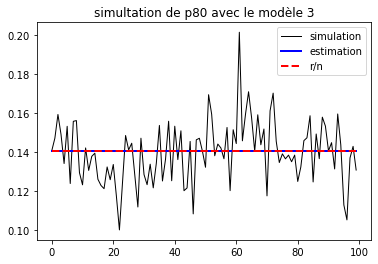

In [21]:
# trace de pj
j = 80

plt.plot(y[::40,[j]], color = 'black', linewidth=1, label='simulation')
plt.plot([np.mean(y[:,[j]])]*100,'b-', linewidth=2, label = 'estimation')
plt.plot([ratio[j]]*100, 'r--', linewidth=2, label = 'r/n')
plt.legend()
plt.title("simultation de p"+str(j) + " avec le modèle 3")

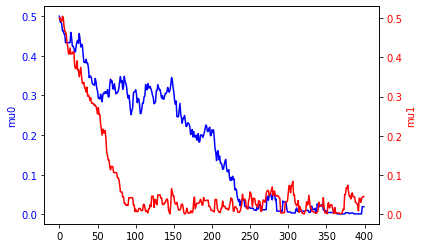

In [23]:
# traces de mu0 et mu1
fig, ax1 = plt.subplots()

ax1.plot(y[0:400,182], 'b-')
ax1.set_ylabel('mu0', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(y[0:400,184], 'r-')
ax2.set_ylabel('mu1', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.savefig('ShareAxes.png')
plt.show()

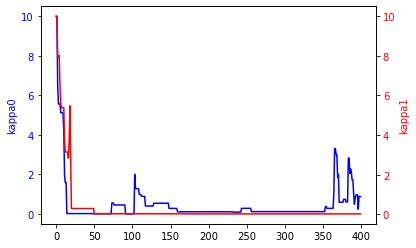

In [24]:
# traces de kappa0 et kappa1
fig, ax1 = plt.subplots()

ax1.plot(y[0:400,183], 'b-')
ax1.set_ylabel('kappa0', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')

ax2 = ax1.twinx()
ax2.plot(y[0:400,185], 'r-')
ax2.set_ylabel('kappa1', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.savefig('ShareAxes.png')
plt.show()

Text(0.5, 1.0, 'autocorrelation des simulations de mu0')

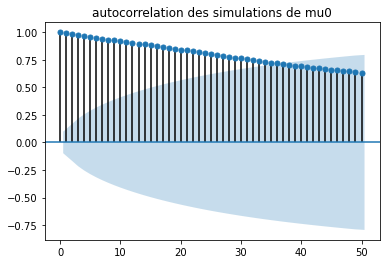

In [28]:
plot_acf(y[0:400,182], lags=50)
plt.title("autocorrelation des simulations de mu0")

Text(0.5, 1.0, 'autocorrelation des simulations de mu1')

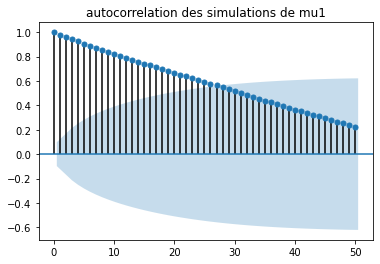

In [29]:
plot_acf(y[0:400,184], lags=50)
plt.title("autocorrelation des simulations de mu1")

Text(0.5, 1.0, 'autocorrelation des simulations de kappa0')

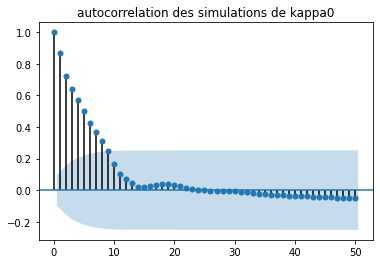

In [27]:
plot_acf(y[0:400,183], lags=50)
plt.title("autocorrelation des simulations de kappa0")

Text(0.5, 1.0, 'autocorrelation des simulations de kappa1')

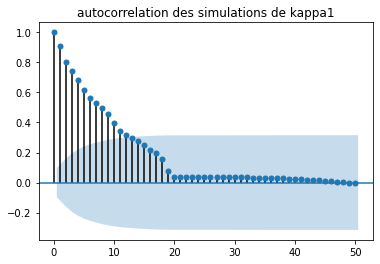

In [30]:
plot_acf(y[0:400,185], lags=50)
plt.title("autocorrelation des simulations de kappa1")

In [31]:
# evolution de la répartition des deux lois de probabilité
list_propor_1=[(y[i,91:182].sum()) for i in range(0,300)]
list_propor_0=[(91-y[i,91:182].sum()) for i in range(0,300)]

Text(0.5, 1.0, 'Répartition des études dans les 2 populations')

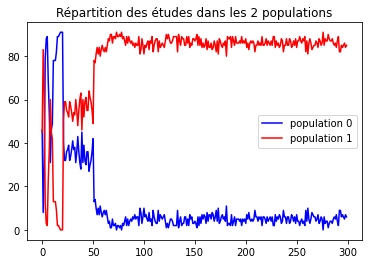

In [49]:
plt.plot(list_propor_0,color='blue',label='population 0')
plt.plot(list_propor_1,color='red',label='population 1')
plt.legend()
plt.title("Répartition des études dans les 2 populations")

In [50]:
pop_1=[]
for j in range(0,91):
    if y[299,91+j]==1:
        pop_1.append(j)
        
df.index[1]

1

In [52]:
# création de la variable population valant 1 ou 0 selon l'étude

df['population']=0 # initialisation

for k in range(0,91):
    if k in pop_1:
        df['population'].iloc[k]=1

/Users/lucietournier/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


/Users/lucietournier/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


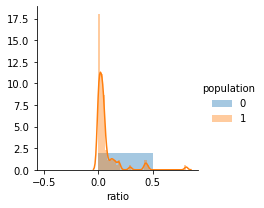

In [54]:
g = sns.FacetGrid(data=df, hue='population')
g.map(sns.distplot, 'ratio').add_legend()
plt.show()

In [ ]:
## Pour le calcul de l'erreur 

In [ ]:
def estimation(n_pts, laps) :
    
    sim = np.zeros((n_pts*laps, 186))

    for i in range (0,91):
        sim[0,i]=df['ratio'][i]           # on prend les probas empiriques comme probas initiales
    
    for i in range(91,182):
        sim[0,i]=np.random.binomial(1,0.5)   # on prend des valeurs au hasard (0 ou 1) comme w_i initiales
        
    sim[0,182]=0.01         
    sim[0,183]=10          # valeur initiale pour kappa0 car kappa0 suit une exp(0.1) donc est de moyenne 10
    sim[0,184]=0.5         # valeur initiale pour mu1 
    sim[0,185]=10   
    
    
    for n in range(1, n_pts*laps):
        sim[n] = metropolis_within_gibbs_melange(sim[n-1],sigma_mu0=0.015,sigma_kap0=2,sigma_mu1=0.015,
                                               sigma_kap1=2,eta=0.5)
        
    
    p = [ np.mean(sim[::laps,l]) for l in range(91)]
    z = [ np.mean(sim[::laps,l]) for l in range(91,182)] 
    mu0 = np.mean( sim[::laps,182] )
    mu1 = np.mean( sim[::laps,184] )
    kap0 = np.mean( sim[::laps,183] )
    kap1 = np.mean( sim[::laps,185] )
    
    return [p,z,mu0,mu1,kap0,kap1]
            

In [ ]:
n_pts = 10

arr_p, arr_z = np.zeros((50,91)), np.zeros((50,91))
arr_mu0, arr_mu1, arr_kap0, arr_kap1 = np.zeros(50), np.zeros(50), np.zeros(50), np.zeros(50)

for i in tqdm(range(50)) :
    arr_p[i], arr_z[i], arr_mu0[i], arr_mu1[i], arr_kap0[i], arr_kap1[i] = estimation(n_pts, 40)
erreur_p = [ np.sqrt(np.var(arr_p[:,[i]])) for i in range(91) ]
erreur_mu0 = np.sqrt(np.var(arr_mu0))
erreur_kap0 = np.sqrt(np.var(arr_kap0))
erreur_mu1 = np.sqrt(np.var(arr_mu1))
erreur_kap1 = np.sqrt(np.var(arr_kap1))

In [ ]:
plt.plot(erreur_p)
print("valeur de mu0 : " + str(np.mean(arr_mu0)) )
print("erreur sur mu0 : " + str(erreur_mu0) )
print("valeur de kappa0 : " + str(np.mean(arr_kap0)) )
print("erreur sur kappa0 : " + str(erreur_kap0) )
print("valeur de mu1 : " + str(np.mean(arr_mu1)) )
print("erreur sur mu1 : " + str(erreur_mu1) )
print("valeur de kappa1 : " + str(np.mean(arr_kap1)) )
print("erreur sur kappa1 : " + str(erreur_kap1) )

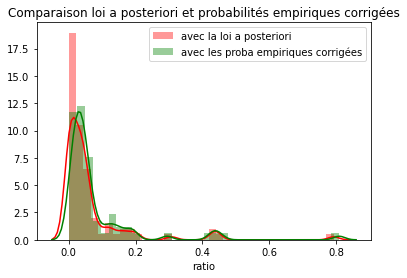

In [59]:
P, z, mu0, mu1, kappa0, kappa1 = estimation(100, 40)

plt.title('Comparaison loi a posteriori et probabilités empiriques corrigées')
sns.distplot(P, color="red", kde=True)
sns.distplot(df['ratio'][df.positive > 0], color="green", kde=True)
plt.legend(['avec la loi a posteriori', 'avec les proba empiriques corrigées'])